# Klustring av bilder
Denna notebook innehåller kod för att utföra attributsextrahering, dimensionsreducering och klustrande med hjälp av olika algoritmer.

In [1]:
#imports

#general
import numpy as np
import pandas as pd
import os
import json
from PIL import Image, ImageFont, ImageDraw     #for creating a cluster collage 
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact
from IPython.display import display
#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
# from kneed import KneeLocator   #used for analysing the optimal k value in K-Means
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

#image
from skimage.color import rgb2gray
from skimage import exposure
from scipy.fftpack import dct, idct
import matplotlib.image as plt_im
from skimage.feature import hog
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Model
from keras.preprocessing.image import load_img    #would not be needed if we use arrays directly, or if we do preprocessing separately

def choose_models(Feature_extraction_method, Dimensionality_reduction, Clustering_algorithm, Text_log, Collage):
    return Feature_extraction_method, Dimensionality_reduction, Clustering_algorithm, Text_log, Collage
model_choices = interactive(choose_models, Feature_extraction_method=['Pixel', 'CNN', 'HOG', 'DCT'], Dimensionality_reduction=["None", "t-SNE","PCA"], Clustering_algorithm=["k-Means","DBSCAN","GMM"], Text_log=True, Collage=True)

## **Modell val**
Innan denna körs, se till att ipywidgets är installerat. Välj sedan modell och kör kodblocket igen när allt är valt.

In [58]:
display(model_choices)
choices=model_choices.result

interactive(children=(Dropdown(description='Feature_extraction_method', index=3, options=('Pixel', 'CNN', 'HOG…

## **Attributeextrahering**
Kör sedan detta kodblock. Här kommer extraheringen som valts i modellen utförast på datamängden. Byt här namn på "foldername" för ett annat dataset. Detta är de mappar som finns i data och sedan datasets

In [59]:
#reading in images filenames
foldername= "sigma5_rotated_border=0.2_only-sigma7"
image_directory = os.path.join("data","datasets",foldername)
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
filenames = []
size = 0
for filename in os.listdir(image_directory):
    if filename.endswith(".jpg"):    #change to .png if you want
        filenames.append(filename)
        size += 1

#calculating the feature for a given image
print("Found ",len(filenames), " images")
#initializing a VGG16 model. We remove the output layer as we just want the rest of the layers to put into our Kmeans model later.
#model = VGG16()
#model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def CalculateFeatureCNN(imagename, model):
    image = load_img(imagename, target_size=(224,224))  #the VGG16 model expects 224 x 224 images. The third dimension is the number of channels.
    image = (np.array(image)).reshape(1,224,224,3)    #VGG16 also needs an additional dimension for batch size.
    processed_image = preprocess_input(image)  
    features = model.predict(processed_image,use_multiprocessing=True)
    features
    return features

#alternative - calculating features directly by looking at pixel values.
def CalculateFeaturePixel(imagename):
    image = load_img(imagename, target_size=(32,32))
    features =(np.array(image)).flatten()
    return features

#using HOG
def CalculateFeatureHOG(imagename, return_image = False, flatten = True):
    image = load_img(imagename, target_size=(32,32))
    features, image_processed = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True, channel_axis=-1, feature_vector = flatten)
    if return_image:
        return image_processed
    else:
        return features
    
#using DCT with zonal masking
def CalculateFeatureDCT(imagename,export=False):
    image = np.array(load_img(imagename, target_size=(32,32)))
    #image_processed = dct(dct(image.T, norm='ortho').T, norm='ortho')
    #image_processed = dct(rgb2gray(image).T, norm='ortho')
    image_processed = dct(dct(rgb2gray(image).T, norm='ortho').T, norm='ortho')
    features = (np.array(image_processed)[0:32,0:32]).flatten()
    if export:
        image_processed = rgb2gray(image_processed)
        return image_processed
    return features

chosen_model = choices[0]        
export_HOG_images = False    #Only relevant for HOG feature extraction, do not use for large amounts of data! Exports HOG images like those seen in the report.
export_DCT_images = False   #Exports DCT images like the one seen in the report. Not needed normally!


#generating features vector. Can be slow for CNN and HOG.
features = {}
if chosen_model == "CNN":
    for index, image in enumerate(filenames):
        feature = CalculateFeatureCNN(os.path.join(image_directory,image),model)
        features[image] = feature   #the feature from VGG16 will be 4096 long.
        print(str(index)+"/"+str(size)+" -- "+str(np.round(100*index/size,1))+"%"  )
    imagenames = np.array(list(features.keys()))
    features = np.array(list(features.values())).reshape(-1,4096)
elif chosen_model == "Pixel":
    for index, image in enumerate(filenames):
        feature = CalculateFeaturePixel(os.path.join(image_directory,image))
        features[image] = feature   
        if index % 50 == 0:
            print(str(index)+"/"+str(size)+"\n"+str(100*index/size)+"%")  
    imagenames = np.array(list(features.keys()))
    features = np.array(list(features.values()))  
elif chosen_model == "HOG":
    for index, image in enumerate(filenames):
        if export_HOG_images:
            HOG_image = CalculateFeatureHOG(os.path.join(image_directory,image),return_image=True, flatten=True)
            HOG_image = exposure.rescale_intensity(HOG_image, in_range=(0,5)) 
            plt.imshow(HOG_image,cmap="gray")
            plt.axis("off")
            plt.savefig("C:\\Users\\William\\Pictures\\HOG_exports\\"+image+".png",bbox_inches="tight")         #ADD YOUR OWN PATHS HERE IF DESIRED        
        
        feature = CalculateFeatureHOG(os.path.join(image_directory,image))
        features[image] = feature   
        print(str(index)+"/"+str(size)+" -- "+str(np.round(100*index/size,1))+"%"  )
    imagenames = np.array(list(features.keys()))
    features = np.array(list(features.values()))
elif chosen_model == "DCT":
    for index, image in enumerate(filenames):
        if export_DCT_images:
            DCT_image = CalculateFeatureDCT(os.path.join(image_directory,image),export=export_DCT_images)
            plt.imshow(DCT_image)
            plt.axis("off")
            plt.savefig("C:\\Users\\William\\Pictures\\HOG_exports\\"+image+"_DCT.png",bbox_inches="tight")         #ADD YOUR OWN PATHS HERE IF DESIRED
        feature = CalculateFeatureDCT(os.path.join(image_directory,image))
        features[image] = feature   
        print(str(index)+"/"+str(size)+" -- "+str(np.round(100*index/size,1))+"%"  )
    imagenames = np.array(list(features.keys()))
    features = np.array(list(features.values()))  

Found  599  images
0/599 -- 0.0%
1/599 -- 0.2%
2/599 -- 0.3%
3/599 -- 0.5%
4/599 -- 0.7%
5/599 -- 0.8%
6/599 -- 1.0%
7/599 -- 1.2%
8/599 -- 1.3%
9/599 -- 1.5%
10/599 -- 1.7%
11/599 -- 1.8%
12/599 -- 2.0%
13/599 -- 2.2%
14/599 -- 2.3%
15/599 -- 2.5%
16/599 -- 2.7%
17/599 -- 2.8%
18/599 -- 3.0%
19/599 -- 3.2%
20/599 -- 3.3%
21/599 -- 3.5%
22/599 -- 3.7%
23/599 -- 3.8%
24/599 -- 4.0%
25/599 -- 4.2%
26/599 -- 4.3%
27/599 -- 4.5%
28/599 -- 4.7%
29/599 -- 4.8%
30/599 -- 5.0%
31/599 -- 5.2%
32/599 -- 5.3%
33/599 -- 5.5%
34/599 -- 5.7%
35/599 -- 5.8%
36/599 -- 6.0%
37/599 -- 6.2%
38/599 -- 6.3%
39/599 -- 6.5%
40/599 -- 6.7%
41/599 -- 6.8%
42/599 -- 7.0%
43/599 -- 7.2%
44/599 -- 7.3%
45/599 -- 7.5%
46/599 -- 7.7%
47/599 -- 7.8%
48/599 -- 8.0%
49/599 -- 8.2%
50/599 -- 8.3%
51/599 -- 8.5%
52/599 -- 8.7%
53/599 -- 8.8%
54/599 -- 9.0%
55/599 -- 9.2%
56/599 -- 9.3%
57/599 -- 9.5%
58/599 -- 9.7%
59/599 -- 9.8%
60/599 -- 10.0%
61/599 -- 10.2%
62/599 -- 10.4%
63/599 -- 10.5%
64/599 -- 10.7%
65/599 -- 1

## **Dimentions reduktion**
Därefter ska detta kodblock köras. Där den dimensionsreducerings medtoderna utförs och sparas undan för att sedan kunna plottas senare. Därefter så sparas i features den metod som har valts innan sosedan kommer användas för fortsatt klustring.

In [55]:
method = choices[1] #which method should be used

#PCA
pca = PCA(n_components = 3)     #n_components = 2 or 3 for visualization, but can be arbitrary larger value
pca.fit(features)
features_PCA = pca.transform(features)

#t-SNE
tSNE = TSNE(n_components=3,verbose=1, perplexity=40, random_state=42)    #n_components = 2 or 3, only allowed options. verbose and perplexity can be adjusted. Play around to find suitable values for our data.
features_tSNE = tSNE.fit_transform(features)

#chooses which features vector is used for the clustering
if method == "None":
    pass
elif method == "PCA":
    features = features_PCA
    print("used PCA")
elif method == "t-SNE":
    features = features_tSNE
    print("used t-SNE")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 599 samples in 0.011s...
[t-SNE] Computed neighbors for 599 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 599 / 599
[t-SNE] Mean sigma: 0.870538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.755234
[t-SNE] KL divergence after 1000 iterations: 0.462380


## **Klustring**
Sedan ska detta kodblock köras. Där utförs den klustrings som valts. Här kan man andära på parametrar som min_- och max_components, k, epsilon och min_samples.

In [56]:
clustering_model = choices[2]       #Choice of which clustering model to use.


#---- PARAMETER CHOICES ---------------------------
n_clusters = 70                    #Desired number of clusters. Only relevant for k-Means and GMM. 
k=n_clusters
min_components= 1
max_components= 30

#DBSCAN parameters
epsilon = 0.7      #The maximum distance between two samples for one to be considered as in the neighborhood of the other.
min_samples = 2  #The number of samples in a neighborhood for a point to be considered as a core point.

#K-Means clustering
if clustering_model == "k-Means":
    k = n_clusters  #number of clusters
    kmeans = KMeans(n_clusters = k,n_init="auto", random_state=42)
    kmeans.fit(features)
    assigned_clusters = kmeans.labels_

#GMM clustering
elif clustering_model == "GMM":                                 #
    bic_scores = []
    for n_components in range(min_components, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(features)
        bic_scores.append(gmm.bic(features))

    n_clusters = np.argmin(bic_scores) + min_components
                                #
    gmm= GaussianMixture(n_components=n_clusters, random_state= 42)
    gmm.fit(features)
    assigned_clusters = gmm.predict(features)

#DBSCAN clustering
elif clustering_model == "DBSCAN":
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    assigned_clusters = dbscan.fit_predict(features)


#creating clustering dictionaries
if clustering_model == "DBSCAN":
    unique_clusters = np.unique(assigned_clusters)
    clusters = {cluster: [] for cluster in unique_clusters}
    n_clusters = len(unique_clusters)
else:
    clusters = {}
    for cluster in range(k):
        clusters[cluster] = []

for index, image in enumerate(imagenames):
    clusters[assigned_clusters[index]].append(image)
print("Finished clustering")

if clustering_model == "DBSCAN":
    name = "ALMA_" + chosen_model + "_dim_reduction="+choices[1] +"_"+clustering_model+"_eps="+str(epsilon)+"_samples="+str(min_samples)
else:
    name = "ALMA_" + chosen_model + "_dim_reduction="+choices[1]+"_"+clustering_model+"_n_clusters="+str(n_clusters) + "featureextractionevaluation"

#log clusters with image names to a txt file. add your own path if you want to log clusters
if choices[3]:
    with open(os.path.join("outputs","logs",name)+".txt","w") as file:
        for key in clusters:
            file.write(str(key)+":\n")
            for value in clusters[key]:
                file.write(value+"\n")
            file.write("\n\n\n")
    print("Finished logging")

#creates the image collages
if choices[4] and clustering_model != "DBSCAN":
    # font settings
    # font = ImageFont.truetype(r'arial.tff', 125)  

    # Create a new big white image to paste the images of the disks
    collage_width = int(64 * n_clusters)
    collage_height = int(64 * (len(max(clusters.values(), key=len)) + 1))
    new = Image.new("RGBA", (collage_width, collage_height), color="white")

    # Iterate through clusters and images
    for cluster in range(n_clusters):
        for index, img_name in enumerate(clusters[cluster]):
            img = Image.open(os.path.join(image_directory, img_name))
            img = img.resize((64, 64))
            new.paste(img, (int(cluster * 64), int((index + 1) * 64)))
        draw = ImageDraw.Draw(new)
        # draw.text(((cluster * 64) + 25, 75), str(cluster), font=font, fill="red", align="center")

    new.save(os.path.join("outputs", "collages", name) + ".png")
    print("Finished collage creation")
    #display(new)


if choices[4] and clustering_model == "DBSCAN":
    collage_width = int(64 * n_clusters)
    collage_height = int(64 * (len(max(clusters.values(), key=len))))
    # Now handle the rest of the clusters
    new = Image.new("RGBA", (collage_width, collage_height), color="white")
    for cluster in unique_clusters:
        for index, img_name in enumerate(clusters[cluster]):
            img = Image.open(os.path.join(image_directory, img_name))
            img = img.resize((64, 64))
            new.paste(img, (int((cluster+1) * 64), int(index * 64)))
    new.save(os.path.join("outputs", "collages",foldername, name) + ".png")
    print("Finished collage creation including -1 cluster")
    #display(new)

Finished clustering
Finished collage creation


## **Skapar jsonfil med information om klusterna**
Om man kör detta kodblock från man en jsonfil men infromation om vilka okjekt, fits-filer och vilken zoomning och rotationsfaktor som dessa bilder utsatts för innan. Detta sparas då i outputs, clusterinfo och sedan mappen för det datasetet som användts.

In [57]:
cluster_info = {}

file_path = os.path.join(image_directory,"image_data.json")

with open(file_path, "r") as json_file:
        json_data = json.load(json_file)

if clustering_model != "DBSCAN":
    for cluster in range(n_clusters):
        cluster_data = []
        for img_name in clusters[cluster]:
            fits_filename = img_name.replace(".fits.jpg", ".fits")
            if fits_filename in json_data:
                info = json_data[fits_filename]
                cluster_data.append({"image_name": fits_filename, "info": info})
        cluster_info[str(cluster)] = cluster_data
else:
    cluster_data = []
    for index, img_name in enumerate(clusters[-1]):
        fits_filename = img_name.replace(".fits.jpg", ".fits")
        if fits_filename in json_data:
            # Get info for the FITS file
            info = json_data[fits_filename]
            cluster_data.append({"image_name": fits_filename, "info": info})
    cluster_info[str(-1)] = cluster_data
    
    for cluster in unique_clusters:
        cluster_data = []
        if cluster == -1:
            continue
        for index, img_name in enumerate(clusters[cluster]):
            fits_filename = img_name.replace(".fits.jpg", ".fits")
            if fits_filename in json_data:
                # Get info for the FITS file
                info = json_data[fits_filename]
                cluster_data.append({"image_name": fits_filename, "info": info})
        cluster_info[str(cluster)] = cluster_data

json_path = os.path.join("outputs", "clusterinfo",foldername, name + ".json")

try:
    # Open the file for writing
    with open(json_path, "w") as json_file:
        json.dump(cluster_info, json_file)
    print("Cluster information saved")
except PermissionError:
    print(f"Permission Denied: Cannot write to the file {json_path}")
except OSError as e:
    print(f"OS error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


print("Cluster information saved")

Cluster information saved
Cluster information saved


## **Evaluation**
Kör detta kodblock om vi vill ha siluette scores på reslutatet med k-means

In [177]:
if clustering_model == "DBSCAN":
    pass

elif clustering_model == "k-Means":
    results = []
    for k2 in range(2,11):
        average = 0
        for times in range(10):
            kmeans2 = KMeans(n_clusters = k2,n_init="auto")
            predictions = kmeans2.fit_predict(features)
            silhouette_avg = silhouette_score(features, predictions)
            average += silhouette_avg/10
        print(k2," clusters: score = ",average)
        results.append(average)
print(results)

NameError: name 'results' is not defined

## **3D plots for PCA and t-SNE**

Kör detta kodblock för att plotta t-SNE och PCA som sparades utan tidiagre.

(599, 1024)


Text(0.5, 0.98, 'PCA')

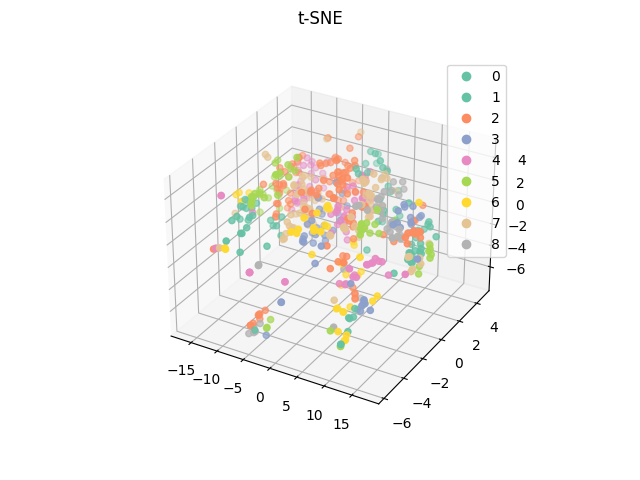

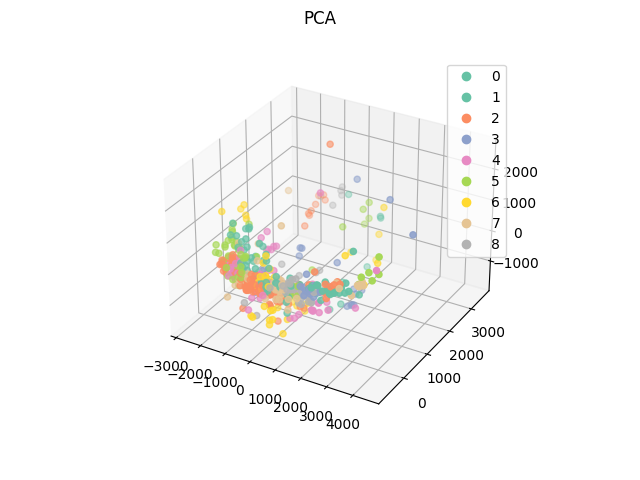

In [52]:
%matplotlib widget 
fig_tSNE = plt.figure()
ax = fig_tSNE.add_subplot(projection="3d")
scatter = ax.scatter(features_tSNE[:,0],features_tSNE[:,1],features_tSNE[:,2],c=assigned_clusters,cmap="Set2",label=assigned_clusters)
ax.legend(handles=scatter.legend_elements()[0], labels=list(range(k)))
fig_tSNE.suptitle("t-SNE")


print(np.shape(features))
fig_PCA = plt.figure()
ax = fig_PCA.add_subplot(projection="3d")
scatter = ax.scatter(features_PCA[:,0],features_PCA[:,1],features_PCA[:,2],c=assigned_clusters,cmap="Set2",label=assigned_clusters)
ax.legend(handles=scatter.legend_elements()[0], labels=list(range(k)))
fig_PCA.suptitle("PCA")